In [ ]:
from lzma import LZMADecompressor, LZMAError, FORMAT_AUTO
from urllib import request
from urllib.error import HTTPError
import struct
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import pyximport
pyximport.install()

import lead_lag

# Below helpful procedures courtesy of terukusu https://github.com/terukusu/download-tick-from-dukascopy
def decompress_lzma(data):
    results = []
    len(data)
    while True:
        decomp = LZMADecompressor(FORMAT_AUTO, None, None)
        try:
            res = decomp.decompress(data)
        except LZMAError:
            if results:
                break
            else:
                raise
        results.append(res)
        data = decomp.unused_data
        if not data:
            break
        if not decomp.eof:
            raise LZMAError("Compressed data ended before the end-of-stream marker was reached")
    return b"".join(results)


def tokenize(buffer):
    token_size = 20
    token_count = int(len(buffer) / token_size)
    tokens = list(map(lambda x: struct.unpack_from('>3I2f', buffer, token_size * x), range(0, token_count)))
    return tokens


def normalize_tick(symbol, day, time, ask, bid, ask_vol, bid_vol):
    date = day + timedelta(milliseconds=time)

    # TODO 網羅する。この通過ペア以外も有るかも
    if any(map(lambda x: x in symbol.lower(), ['usdrub', 'xagusd', 'xauusd', 'jpy'])):
        point = 1000
    else:
        point = 100000

    return [date, ask/point, bid/point, round(ask_vol * 1000000), round(bid_vol * 1000000)]


def download_ticks(symbol, day, hours=(0, 24)):
    url_prefix='https://datafeed.dukascopy.com/datafeed'

    ticks_day = []
    for h in range(hours[0], hours[1]):
        file_name = f'{h:02d}h_ticks.bi5'
        url = f'{url_prefix}/{symbol}/{day.year:04d}/{day.month-1:02d}/{day.day:02d}/{file_name}'
        print(f'downloading: {url}')

        req = request.Request(url)
        try:
            with request.urlopen(req) as res:
                res_body = res.read()
        except HTTPError:
            print('download failed. continuing..')
            continue

        if len(res_body):
            try:
                data = decompress_lzma(res_body)
            except LZMAError:
                print('decompress failed. continuing..')
                continue
        else:
            data = []

        tokenized_data = tokenize(data)
        ticks_hour = list(map(lambda x: normalize_tick(symbol, day + timedelta(hours=h), *x), tokenized_data))
        ticks_day.extend(ticks_hour)

    return ticks_day


def format_to_csv_for_ticks(ticks):
    return '\n'.join(map(lambda x: '{},{},{},{},{}'.format(x[0].strftime('%Y-%m-%d %H:%M:%S.%f'), *x[1:]), ticks))+'\n'

In [36]:
def pearson_correlation(x, y):
    assert len(x) == len(y)
    x_centered = x - np.mean(x)
    y_centered = y - np.mean(y)
    r = np.sum(x_centered * y_centered)
    r /= np.sqrt(np.sum(x_centered ** 2) * np.sum(y_centered ** 2))
    return r

def ll_ratio(price_1, price_2, lags):
    lr_1 = np.diff(np.log(price_1))
    lr_2 = np.diff(np.log(price_2))
    cross_corr = [pearson_correlation(lr_1, lr_2)]
    for i in range(1, lags+1, 1):
        cross_corr.append(pearson_correlation(lr_1[i:], lr_2[:-i]))
        cross_corr.insert(0, pearson_correlation(lr_1[:-i], lr_2[i:]))
    llr = np.sum(np.array(cross_corr[:lags]) ** 2) / np.sum(np.array(cross_corr[lags+1:]) ** 2)
    return llr

def lead_lag_estimate(price_1, price_2, max_lag, corr=pearson_correlation):
    lr_1 = np.diff(np.log(price_1))
    lr_2 = np.diff(np.log(price_2))
    cross_corr = [corr(lr_1, lr_2)]
    for i in range(1, max_lag+1, 1):
        cross_corr.append(corr(lr_1[:-i], lr_2[i:]))
        cross_corr.insert(0, corr(lr_1[i:], lr_2[:-i]))
    llr = np.sum(np.array(cross_corr[max_lag+1:]) ** 2) / np.sum(np.array(cross_corr[:max_lag]) ** 2)
    return llr, cross_corr

def pearson_cross_correlation(price_1, price_2, max_lag):
    x = np.diff(np.log(price_1))
    y = np.diff(np.log(price_2))
    cross_corr = [pearson_correlation(x, y)]
    for i in range(1, max_lag+1, 1):
        cross_corr.append(pearson_correlation(x[:-i], y[i:]))
        cross_corr.insert(0, pearson_correlation(x[i:], y[:-i]))
    return cross_corr

def lead_lag_ratio(cross_corr):
    max_lag = int((len(cross_corr) - 1) / 2)
    return np.sum(np.array(cross_corr[max_lag+1:]) ** 2) / np.sum(np.array(cross_corr[:max_lag]) ** 2)

Import of One Trading Date of FX Tick Data

In [86]:
date = datetime.strptime('2025-08-29', '%Y-%m-%d')
trading_hours = (8, 18)  # Trading hours in UTC
ccies = ['USDJPY', 'USDZAR']

ticks = download_ticks(ccies[0], date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts1_ticks = df_ticks['mid'].copy()
ticks = download_ticks(ccies[1], date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts2_ticks = df_ticks['mid'].copy()

del ticks
del df_ticks

# Drop ticks with no price change
ts1_ticks = ts1_ticks[(ts1_ticks != ts1_ticks.shift(1))]
ts2_ticks = ts2_ticks[(ts2_ticks != ts2_ticks.shift(1))]


downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/

Epps Effect and Hayashi-Yoshida Estimator

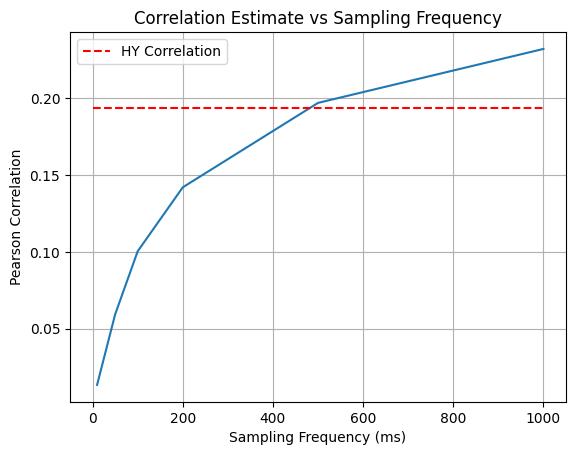

In [100]:
freqs = [10, 50, 100, 200, 500, 1000]
corellation_results = []

for freq in freqs:
    sampling = str(freq) + 'ms'
    ts1 = ts1_ticks.resample(sampling).last().ffill()
    ts2 = ts2_ticks.resample(sampling).last().ffill()
    df_sampled = pd.DataFrame({'ts1': ts1, 'ts2': ts2}).dropna()
    corellation_results.append(pearson_correlation(np.diff(np.log(df_sampled['ts1'])), np.diff(np.log(df_sampled['ts2']))))

ll = lead_lag.LeadLag(
    ts1=np.log(ts1_ticks),
    ts2=np.log(ts2_ticks),
    max_lag=1,  # [-X seconds, +X seconds]
    verbose=False,
    min_precision=0.01
)
ll.run_inference(num_threads=1)

plt.plot(freqs, corellation_results)
plt.hlines(y=ll.contrasts[100], xmax=1000, xmin=0, color='r', linestyle='--', label='HY Correlation')
plt.xlabel('Sampling Frequency (ms)')
plt.ylabel('Pearson Correlation')
plt.title('Correlation Estimate vs Sampling Frequency')
plt.grid()
plt.legend()
plt.show()

Cross Correlation Lead-Lag Inference and Lead-Lag Ratio

Lead-Lag Ratio: 3.3045
Lag at Max Correlation: 20.0 ms


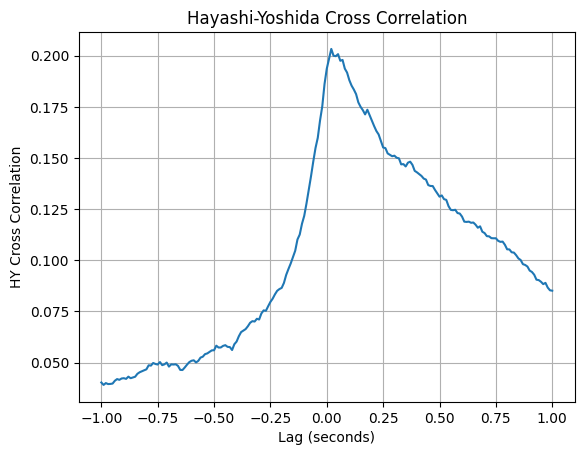

In [94]:
hy_cross_corr = ll.contrasts
print(f'Lead-Lag Ratio: {lead_lag_ratio(hy_cross_corr):.4f}')
print(f'Lag at Max Correlation: {ll.lag_range[np.argmax(hy_cross_corr)] * ll.precision * 1000} ms')

plt.plot(ll.lag_range * ll.precision, hy_cross_corr)
plt.xlabel('Lag (seconds)')
plt.ylabel('HY Cross Correlation')
plt.title('Hayashi-Yoshida Cross Correlation')
plt.grid()
plt.show()

Average Cross Corrlation and Lead-Lag Ratio for period

downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/08h_ticks.bi5


downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/01/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/01/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/

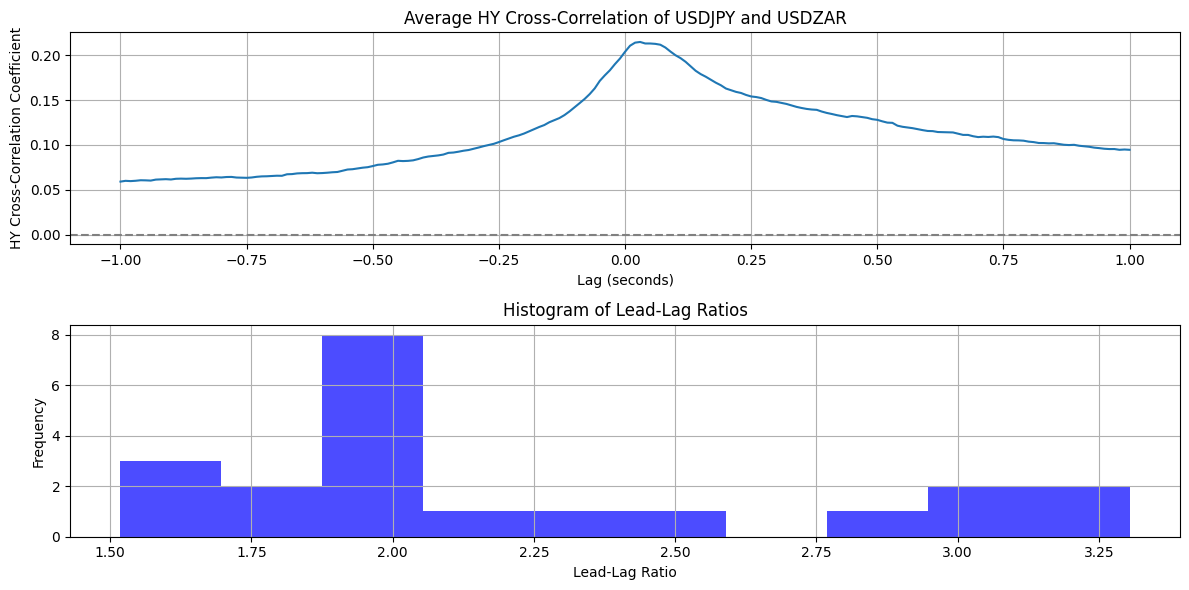

In [98]:
start_date = datetime.strptime('2025-08-01', '%Y-%m-%d')
end_date = datetime.strptime('2025-08-29', '%Y-%m-%d')
ccies = ['USDJPY', 'USDZAR']
date_range = pd.date_range(start=start_date, end=end_date, freq='B')
trading_hours = (8, 18)  # Trading hours in UTC

df_llr = pd.Series(index=date_range, dtype=float)
df_cross_corr = pd.DataFrame(index=date_range, columns=ll.lag_range * ll.precision, dtype=float)
for date in date_range:
    ticks = download_ticks(ccies[0], date, hours=trading_hours)
    df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
    df_ticks.set_index('datetime', inplace=True)
    df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
    ts1_ticks = df_ticks['mid'].copy()
    ticks = download_ticks(ccies[1], date, hours=trading_hours)
    df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
    df_ticks.set_index('datetime', inplace=True)
    df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
    ts2_ticks = df_ticks['mid'].copy()

    del ticks
    del df_ticks

    # Drop ticks with no price change
    ts1_ticks = ts1_ticks[(ts1_ticks != ts1_ticks.shift(1))]
    ts2_ticks = ts2_ticks[(ts2_ticks != ts2_ticks.shift(1))]

    ll = lead_lag.LeadLag(
        ts1=np.log(ts1_ticks),
        ts2=np.log(ts2_ticks),
        max_lag=1,  # [-X seconds, +X seconds]
        verbose=False,
        min_precision=0.01
    )
    ll.run_inference()
    df_llr[date] = lead_lag_ratio(ll.contrasts)
    df_cross_corr.loc[date] = ll.contrasts

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(df_cross_corr.columns, df_cross_corr.mean())
ax[0].set_title('Average HY Cross-Correlation of {} and {}'.format(ccies[0], ccies[1]))
ax[0].set_xlabel('Lag (seconds)')
ax[0].set_ylabel('HY Cross-Correlation Coefficient')
ax[0].axhline(0, color='gray', linestyle='--')
ax[0].grid()
ax[1].hist(df_llr, bins=10, alpha=0.7, color='blue')
ax[1].set_title('Histogram of Lead-Lag Ratios')
ax[1].set_xlabel('Lead-Lag Ratio')
ax[1].set_ylabel('Frequency')
ax[1].grid()
plt.tight_layout()
plt.show()

Pairwise Lead-Lag Analysis for multiple instruments

In [101]:
ccies = ['EURUSD', 'USDJPY', 'GBPUSD']
pairs = [(c1, c2) for i, c1 in enumerate(ccies) for c2 in ccies[i+1:]]

start_date = datetime.strptime('2025-08-26', '%Y-%m-%d')
end_date = datetime.strptime('2025-08-29', '%Y-%m-%d')
date_range = pd.date_range(start=start_date, end=end_date, freq='B')
trading_hours = (8, 18)  # Trading hours in UTC

llr_matrix = pd.DataFrame(data=0,index=ccies, columns=ccies, dtype=float)
ll_matrix = pd.DataFrame(data=0,index=ccies, columns=ccies, dtype=float)

for date in date_range:
    mids = {}
    for c in ccies:
        ticks = download_ticks(c, date, hours=trading_hours)
        df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
        df_ticks.set_index('datetime', inplace=True)
        mids[c] = (df_ticks['ask'] + df_ticks['bid']) / 2
    for pair in pairs:
        x = mids[pair[0]]
        y = mids[pair[1]]
        x = x[(x != x.shift(1))]
        y = y[(y != y.shift(1))]
        ll = lead_lag.LeadLag(
            ts1=np.log(x),
            ts2=np.log(y),
            max_lag=1,  # [-X seconds, +X seconds]
            verbose=False,
            min_precision=0.01
        )
        ll.run_inference(num_threads=1)
        llr = lead_lag_ratio(ll.contrasts)
        ll = ll.lag_range[np.argmax(ll.contrasts)] * ll.precision * 1000
        llr_matrix.loc[pair[0], pair[1]] += llr
        llr_matrix.loc[pair[1], pair[0]] += 1 / llr
        ll_matrix.loc[pair[0], pair[1]] += ll
        ll_matrix.loc[pair[1], pair[0]] += -ll
llr_matrix /= len(date_range)
ll_matrix /= len(date_range)
for c in ccies: llr_matrix.loc[c, c] = 1.0

llr_matrix.style.format(precision=4, na_rep='-').set_properties(**{'text-align': 'right'})
ll_matrix.style.format(precision=0, na_rep='-').set_properties(**{'text-align': 'right'})

downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/26/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/26/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/26/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/26/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/26/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/26/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/26/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/26/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/26/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/26/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/26/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/

,EURUSD,USDJPY,GBPUSD
EURUSD,0,0,10
USDJPY,0,0,8
GBPUSD,-10,-8,0


In [102]:
llr_matrix.style.format(precision=4, na_rep='-').set_properties(**{'text-align': 'right'})

,EURUSD,USDJPY,GBPUSD
EURUSD,1.0000,0.9262,1.0225
USDJPY,1.0909,1.0000,1.1488
GBPUSD,0.9825,0.8766,1.0000


----------

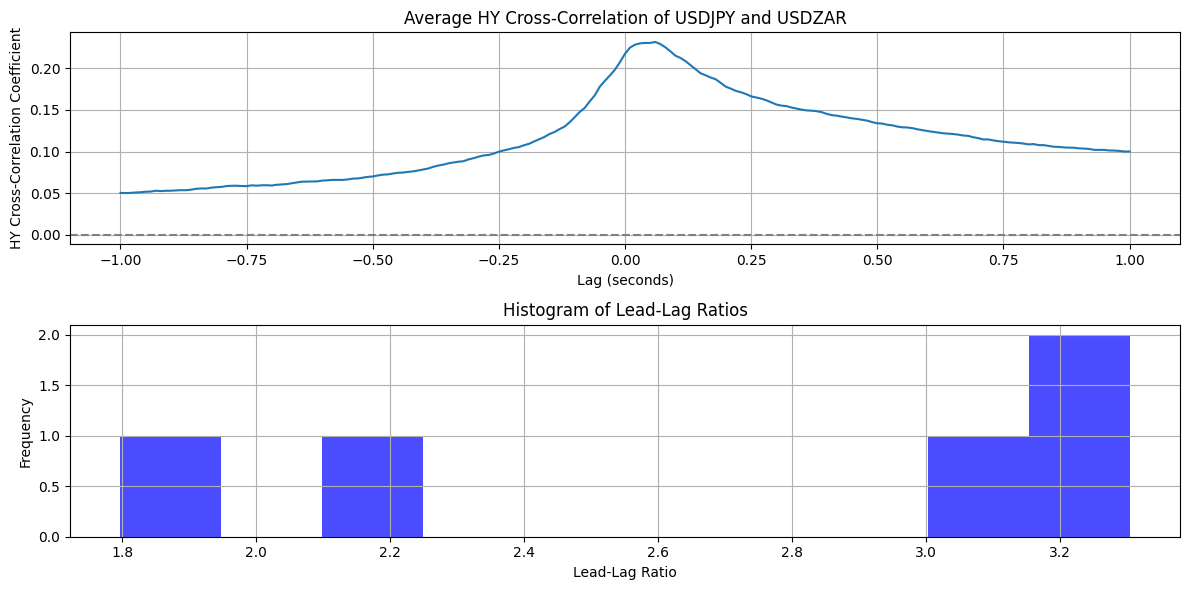

In [97]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(df_cross_corr.columns, df_cross_corr.mean())
ax[0].set_title('Average HY Cross-Correlation of {} and {}'.format(ccies[0], ccies[1]))
ax[0].set_xlabel('Lag (seconds)')
ax[0].set_ylabel('HY Cross-Correlation Coefficient')
ax[0].axhline(0, color='gray', linestyle='--')
ax[0].grid()
ax[1].hist(df_llr, bins=10, alpha=0.7, color='blue')
ax[1].set_title('Histogram of Lead-Lag Ratios')
ax[1].set_xlabel('Lead-Lag Ratio')
ax[1].set_ylabel('Frequency')
ax[1].grid()
plt.tight_layout()
plt.show()

In [ ]:
date = datetime.strptime('2025-08-29', '%Y-%m-%d')
trading_hours = (8, 18)  # Trading hours in UTC

ticks = download_ticks('EURUSD', date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts1 = df_ticks['mid'].copy()
ticks = download_ticks('USDZAR', date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts2 = df_ticks['mid'].copy()
del ticks
del df_ticks

ll = lead_lag.LeadLag(
    ts1=np.log(ts1),
    ts2=np.log(ts2),
    max_lag=1,  # [-X seconds, +X seconds]
    verbose=False,
    min_precision=0.1
)
ll.run_inference()
hy_cross_corr = ll.contrasts
print(f'Lead-Lag Ratio: {lead_lag_ratio(hy_cross_corr):.4f}')

freq = 100
sampling = str(freq) + 'ms'
n_lags = 10

ts1 = ts1.resample(sampling).last().ffill()
ts2 = ts2.resample(sampling).last().ffill()
df_sampled = pd.DataFrame({'ts1': ts1, 'ts2': ts2}).dropna()
pearson_cross_corr = pearson_cross_correlation(df_sampled['ts1'], df_sampled['ts2'], n_lags)
llr = lead_lag_ratio(pearson_cross_corr)
print(f'Cross-correlation LLR for {date.strftime("%Y-%m-%d")}: {llr:.4f}')



downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/

downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/

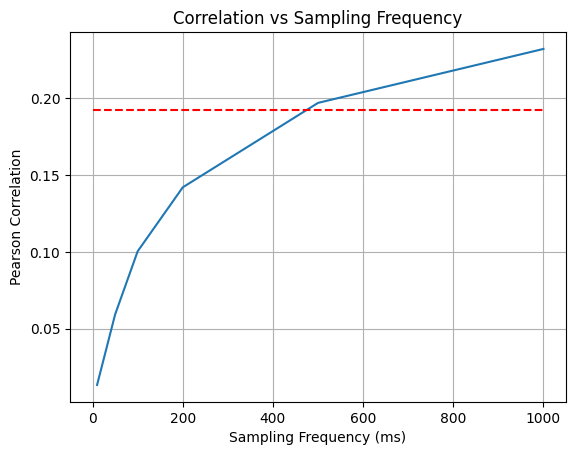

In [75]:
date = datetime.strptime('2025-08-29', '%Y-%m-%d')
trading_hours = (8, 18)  # Trading hours in UTC

ticks = download_ticks('USDJPY', date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts1_ticks = df_ticks['mid'].copy()
ticks = download_ticks('USDZAR', date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts2_ticks = df_ticks['mid'].copy()
del ticks
del df_ticks

freqs = [10, 50, 100, 200, 500, 1000]
corellation_results = []
for freq in freqs:
    sampling = str(freq) + 'ms'
    ts1 = ts1_ticks.resample(sampling).last().ffill()
    ts2 = ts2_ticks.resample(sampling).last().ffill()
    df_sampled = pd.DataFrame({'ts1': ts1, 'ts2': ts2}).dropna()
    corellation_results.append(pearson_correlation(np.diff(np.log(df_sampled['ts1'])), np.diff(np.log(df_sampled['ts2']))))

ll = lead_lag.LeadLag(
    ts1=np.log(ts1_ticks),
    ts2=np.log(ts2_ticks),
    max_lag=1,  # [-X seconds, +X seconds]
    verbose=False,
    min_precision=0.01
)
ll.run_inference()
plt.plot(freqs, corellation_results)
plt.hlines(y=ll.contrasts[100], xmax=1000, xmin=0, color='r', linestyle='--', label='HY Correlation')
plt.xlabel('Sampling Frequency (ms)')
plt.ylabel('Pearson Correlation')
plt.title('Correlation vs Sampling Frequency')
plt.grid()
plt.show()

In [76]:
ll = lead_lag.LeadLag(
    ts1=np.log(ts1_ticks),
    ts2=np.log(ts2_ticks),
    max_lag=1,  # [-X seconds, +X seconds]
    verbose=True,
    min_precision=0.1
)
ll.run_inference()
print(f'Lead-Lag Ratio: {lead_lag_ratio(ll.contrasts):.4f}')

Precision = 100.0 ms.
Running slow_inference() on (-10:10) with 1 thread.
Lag=-10, contrast=0.04850, elapsed=100.32ms.
Lag=-9, contrast=0.05068, elapsed=92.84ms.
Lag=-8, contrast=0.05538, elapsed=98.74ms.
Lag=-7, contrast=0.05622, elapsed=202.29ms.
Lag=-6, contrast=0.06368, elapsed=150.28ms.
Lag=-5, contrast=0.07635, elapsed=155.62ms.
Lag=-4, contrast=0.08617, elapsed=155.33ms.
Lag=-3, contrast=0.10584, elapsed=139.70ms.
Lag=-2, contrast=0.12256, elapsed=311.58ms.
Lag=-1, contrast=0.15865, elapsed=115.59ms.
Lag=0, contrast=0.20134, elapsed=355.42ms.
Lag=1, contrast=0.22297, elapsed=142.51ms.
Lag=2, contrast=0.21660, elapsed=220.33ms.
Lag=3, contrast=0.21126, elapsed=159.69ms.
Lag=4, contrast=0.19615, elapsed=126.62ms.
Lag=5, contrast=0.18684, elapsed=95.54ms.
Lag=6, contrast=0.17763, elapsed=99.27ms.
Lag=7, contrast=0.16200, elapsed=236.12ms.
Lag=8, contrast=0.15272, elapsed=185.11ms.
Lag=9, contrast=0.13940, elapsed=322.75ms.
Lag=10, contrast=0.12395, elapsed=252.55ms.
Lead-Lag Ratio:

In [77]:
ll.contrasts[10]

0.20134191341897062

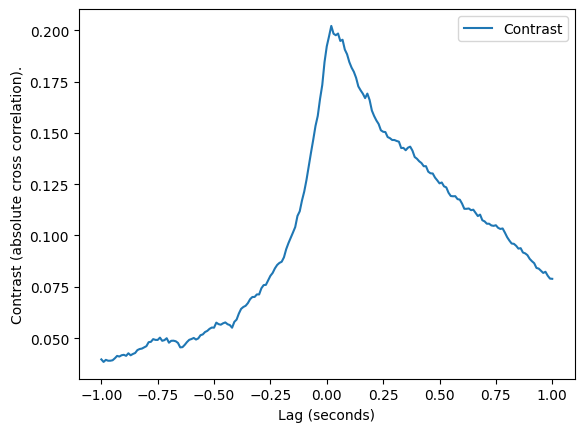

In [70]:
ll.plot_results()

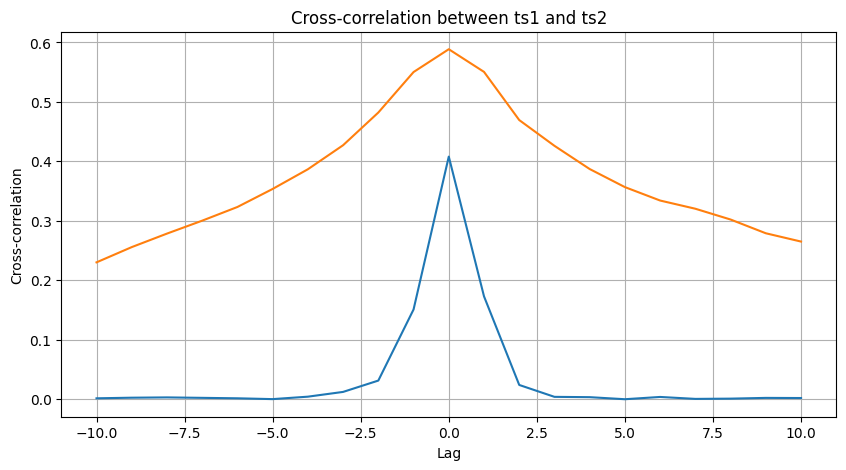

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(range(-n_lags, n_lags+1), np.abs(pearson_cross_corr))
plt.plot(range(-n_lags, n_lags+1), np.abs(hy_cross_corr))
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between ts1 and ts2')
plt.grid()
plt.show()

In [4]:
%pip install git+https://github.com/akaufman22/qftools.git

  Cloning https://github.com/akaufman22/qftools.git to /private/var/folders/44/shglypds2hd5yy5kdnt586h00000gn/T/pip-req-build-33m91ew2
  Running command git clone --filter=blob:none --quiet https://github.com/akaufman22/qftools.git /private/var/folders/44/shglypds2hd5yy5kdnt586h00000gn/T/pip-req-build-33m91ew2
  Resolved https://github.com/akaufman22/qftools.git to commit 9a522a31bb14a8f2520fa7474cedc136202ef2dd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for QuantFinanceTools: filename=quantfinancetools-0.1.0-py3-none-any.whl size=10303 sha256=a7a8f423974386a2f9f9a1da9de3bbdf073334b5654ed28eb5ed2561e27056af
  Stored in directory: /private/var/folders/44/shglypds2hd5yy5kdnt586h00000gn/T/pip-ephem-wheel-cache-60qae2l2/wheels/7d/0f/00/390b57f413ef1f381c864d6317995e23e7ead8f1046c4010dc
Successfully built QuantFinanceTools

[notice] A new release of pip is available: 25.1.1 -> 25.2
[n

In [89]:
from qftools import generate_gbm

ts = generate_gbm(1, 3600 * 8, 0, 0.3, 100).reshape(-1)
ts2 = ts[2:]
ts1 = ts[:-2]

In [18]:
cross_corr

[-0.0049685015360025325,
 -0.0010013631958707492,
 -0.0010114383665810712,
 -0.0033481101768508227,
 -0.0012928860129999909,
 -0.0028680514161354967,
 -0.0032057121400340116,
 -0.006864609914981822,
 -0.014499924851660241,
 -0.04785389521469728,
 -0.14384015363019856,
 -0.14792452802933198,
 -0.10620766428750424,
 -0.05144694540572149,
 -0.025214603586449225,
 -0.013181869541489052,
 -0.010232638471137517,
 -0.008786106764677191,
 -0.00433876382938753,
 -0.00758909543708702,
 -0.003631506936986746]

In [30]:
pearson_cross_corr

[-0.14260796640715628,
 -0.14257719576703023,
 -0.14257554670287,
 -0.14257554554866353,
 -0.14257392476409445,
 -0.14257227580475051,
 -0.14257209887139902,
 -0.1425719219412232,
 -0.142570301314808,
 -0.14257030758773467,
 -0.14260226522550834,
 -0.14255934574743337,
 -0.1425595480829984,
 -0.14255953270846589,
 -0.14255952757617577,
 -0.1425595224438351,
 -0.1425595377965209,
 -0.14255952242165704,
 -0.14255955029549824,
 -0.14255956564012595,
 -0.14255963216840586]

In [91]:
df = pd.DataFrame(index=pd.date_range(start='2024-06-10 00:00:02', end='2024-06-10 08:00:00', freq='s'), data={'A': ts1, 'B': ts2})
#llr = ll_ratio(df['A'].values, df['B'].values, 10)
llr, _ = lead_lag_estimate(df['A'].values, df['B'].values, 10)
llr

0.00027807937244531773

In [ ]:
ll = lead_lag.LeadLag(
    ts1=df['A'],
    ts2=df['B'],
    max_lag=10,
    min_precision=1)
ll.run_inference() 
ll.llr # [-X seconds, +X seconds]

1.0000372212348811

In [35]:
date = datetime.strptime('2025-08-29', '%Y-%m-%d')
trading_hours = (8, 18)  # Trading hours in UTC

ticks = download_ticks('EURUSD', date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts1 = df_ticks['mid'].copy()
ticks = download_ticks('USDZAR', date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts2 = df_ticks['mid'].copy()
del ticks
del df_ticks

ll = lead_lag.LeadLag(
    ts1=ts1,
    ts2=ts2,
    max_lag=1,  # [-X seconds, +X seconds]
    verbose=False,
    min_precision=0.1
)
ll.run_inference()
print(f'Lead-lag LLR for {date.strftime("%Y-%m-%d")}: {ll.llr:.4f}')

freq = 100
sampling = str(freq) + 'ms'
n_lags = 10

ts1 = ts1.resample(sampling).last().ffill()
ts2 = ts2.resample(sampling).last().ffill()
df_sampled = pd.DataFrame({'ts1': ts1, 'ts2': ts2}).dropna()
#llr = ll_ratio(df_sampled['ts1'].values, df_sampled['ts2'].values, n_lags)
llr, cross_corr = lead_lag_estimate(df_sampled['ts1'].values, df_sampled['ts2'].values, n_lags)
print(f'Cross-correlation LLR for {date.strftime("%Y-%m-%d")}: {llr:.4f}')

downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/

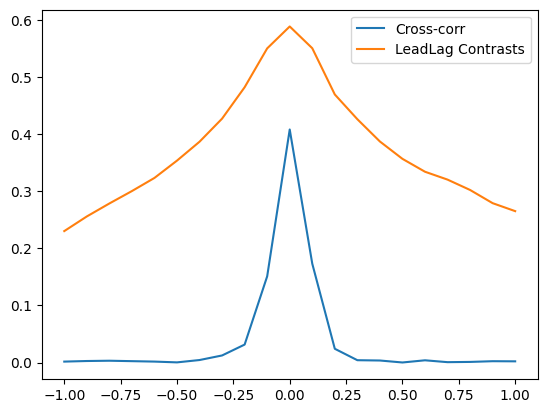

In [121]:
#plt.plot(np.arange(-n_lags, n_lags+1), np.abs(cross_corr))
#plt.show()
ll_contrasts_df = ll._contrasts_to_df()
plt.plot(ll_contrasts_df.index, np.abs(cross_corr), label='Cross-corr')
if hasattr(ll_contrasts_df, 'values'):
	plt.plot(ll_contrasts_df.index, np.abs(ll_contrasts_df.values), label='LeadLag Contrasts')
plt.legend()
plt.show()

In [111]:
ll.cc.slow_inference()

array([0.23017397, 0.25581116, 0.27852077, 0.30025993, 0.32327019,
       0.35359422, 0.38669784, 0.42712702, 0.4820901 , 0.55013694,
       0.5885224 , 0.55042183, 0.46941742, 0.42610421, 0.38707712,
       0.35668742, 0.33410632, 0.32031852, 0.30217834, 0.27907641,
       0.26511304])

In [112]:
ll.contrasts

array([0.23017397, 0.25581116, 0.27852077, 0.30025993, 0.32327019,
       0.35359422, 0.38669784, 0.42712702, 0.4820901 , 0.55013694,
       0.5885224 , 0.55042183, 0.46941742, 0.42610421, 0.38707712,
       0.35668742, 0.33410632, 0.32031852, 0.30217834, 0.27907641,
       0.26511304])

downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/22/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/22/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/22/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/22/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/22/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/22/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/22/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/22/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/22/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/22/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/22/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/

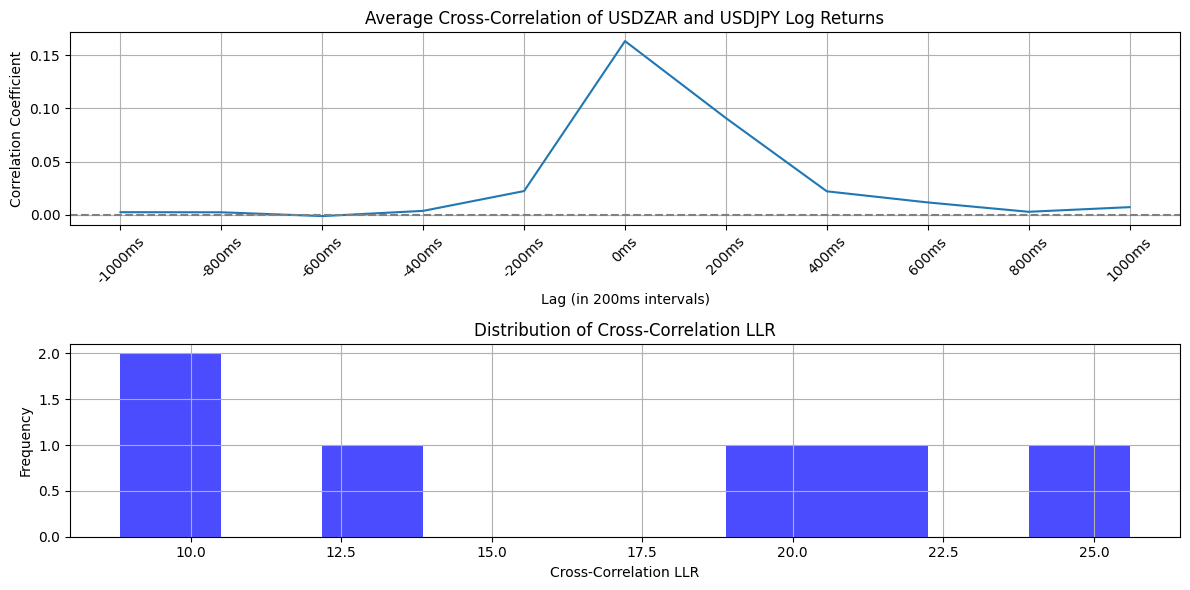

In [3]:
pairs = ('USDZAR', 'USDJPY')
start_date = datetime.strptime('2025-08-22', '%Y-%m-%d')
end_date = datetime.strptime('2025-08-29', '%Y-%m-%d')
date_range = pd.date_range(start=start_date, end=end_date, freq='B')
freq = 200
sampling = str(freq) + 'ms'  # Sampling frequency
trading_hours = (8, 18)  # Trading hours in UTC
n_lags = 5

df_llr = pd.Series(index=date_range, dtype=float)
df_cross_corr = pd.DataFrame(index=date_range, columns=range(-n_lags, n_lags+1), dtype=float)
for date in date_range:
    
    df_prev_tick = pd.DataFrame(columns=pairs, index=pd.date_range(start=date, end=date + timedelta(days=1), freq=sampling))
    for pair in pairs:
        print(f'Downloading ticks for {pair} on {date.strftime("%Y-%m-%d")}')
        ticks = download_ticks(pair, date, hours=trading_hours)
        df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
        del ticks
        df_ticks.set_index('datetime', inplace=True)
        df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
        df_prev_tick[pair] = df_ticks['mid'].resample(sampling).last().ffill()
    df_prev_tick.dropna(inplace=True)
    df_logret = (np.log(df_prev_tick).diff() * 10000).dropna()
    x, y = df_logret[pairs[0]], df_logret[pairs[1]]
    cross_corr = [np.corrcoef(x, y)[0, 1]]
    for i in range(1, n_lags+1, 1):
        cross_corr.append(np.corrcoef(x[i:], y[:-i])[0, 1])
        cross_corr.insert(0, np.corrcoef(x[:-i], y[i:])[0, 1])
    llr = np.sum(np.array(cross_corr[n_lags+1:]) ** 2) / np.sum(np.array(cross_corr[:n_lags]) ** 2)
    print(f'Cross-correlation LLR for {date.strftime("%Y-%m-%d")}: {llr:.4f}')
    df_llr[date] = llr
    df_cross_corr.loc[date] = cross_corr

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(df_cross_corr.mean(axis=0).to_numpy())
ax[0].set_title('Average Cross-Correlation of {} and {} Log Returns'.format(pairs[0], pairs[1]))
ax[0].set_xlabel('Lag (in {} intervals)'.format(sampling))
ax[0].set_xticks(range(len(df_cross_corr.columns)))
ax[0].set_xticklabels([f'{i*freq}ms' for i in range(-n_lags, n_lags+1)], rotation=45)
ax[0].set_ylabel('Correlation Coefficient')
ax[0].axhline(0, color='gray', linestyle='--')
ax[0].grid()
ax[1].hist(df_llr.dropna(), bins=10, alpha=0.7, color='blue')
ax[1].set_title('Distribution of Cross-Correlation LLR')
ax[1].set_xlabel('Cross-Correlation LLR')
ax[1].set_ylabel('Frequency')
ax[1].grid()
plt.tight_layout()
plt.show()



In [2]:
def pearson_correlation(x, y):
    assert len(x) == len(y)
    x_centered = x - np.mean(x)
    y_centered = y - np.mean(y)
    r = np.sum(x_centered * y_centered)
    r /= np.sqrt(np.sum(x_centered ** 2) * np.sum(y_centered ** 2))
    return r

def ll_ratio(price_1, price_2, lags):
    lr_1 = np.diff(np.log(price_1))
    lr_2 = np.diff(np.log(price_2))
    cross_corr = [pearson_correlation(lr_1, lr_2)]
    for i in range(1, lags+1, 1):
        cross_corr.append(pearson_correlation(lr_1[i:], lr_2[:-i]))
        cross_corr.insert(0, pearson_correlation(lr_1[:-i], lr_2[i:]))
    llr = np.sum(np.array(cross_corr[lags+1:]) ** 2) / np.sum(np.array(cross_corr[:lags]) ** 2)
    return llr

In [5]:
from qftools import generate_gbm

gbm = generate_gbm(1, 100, 0, 1, 100, 1, 42).reshape(-1)
ts2 = gbm[:-1]
ts1 = gbm[1:]


n_lags = 10

llr = ll_ratio(ts1, ts2, n_lags)
"""

cross_corr = [pearson_correlation(x, y)] #[np.corrcoef(x, y)[0, 1]]
for i in range(1, n_lags+1, 1):
    cross_corr.append(pearson_correlation(x[i:], y[:-i]))
    cross_corr.insert(0, pearson_correlation(x[:-i], y[i:]))
llr = np.sum(np.array(cross_corr[n_lags+1:]) ** 2) / np.sum(np.array(cross_corr[:n_lags]) ** 2)
"""
print(f'Cross-correlation LLR for {date.strftime("%Y-%m-%d")}: {llr:.4f}')

plt.plot(cross_corr)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Correlation Coefficient')
plt.grid()
plt.show()

ModuleNotFoundError: No module named 'qftools'

In [6]:
1/llr

0.09259933762664148

In [6]:
ccies = ['EURUSD', 'USDJPY', 'GBPUSD', 'USDCHF', 'AUDUSD', 'USDZAR', 'USDMXN', 'USDTRY']
pairs = [(c1, c2) for i, c1 in enumerate(ccies) for c2 in ccies[i+1:]]

start_date = datetime.strptime('2025-08-01', '%Y-%m-%d')
end_date = datetime.strptime('2025-08-29', '%Y-%m-%d')
date_range = pd.date_range(start=start_date, end=end_date, freq='B')
freq = 200
sampling = str(freq) + 'ms'  # Sampling frequency
trading_hours = (8, 18)  # Trading hours in UTC
n_lags = 5

llr_matrix = pd.DataFrame(data=0,index=ccies, columns=ccies, dtype=float)

for date in date_range:
    df_sample = pd.DataFrame(index=pd.date_range(start=date, end=date + timedelta(days=1), freq=sampling))
    for c in ccies:
        ticks = download_ticks(c, date, hours=trading_hours)
        df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
        df_ticks.set_index('datetime', inplace=True)
        df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
        df_sample[c] = df_ticks['mid'].resample(sampling).last().ffill().dropna()
    df_sample.dropna(inplace=True)
    for pair in pairs:
        x = df_sample[pair[0]]
        y = df_sample[pair[1]]
        llr = ll_ratio(x, y, n_lags)
        llr_matrix.loc[pair[0], pair[1]] += llr
        llr_matrix.loc[pair[1], pair[0]] += 1 / llr
llr_matrix /= len(date_range)
for c in ccies: llr_matrix.loc[c, c] = 1.0

llr_matrix.style.format(precision=4, na_rep='-').set_properties(**{'text-align': 'right'})

downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/01/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/01/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/01/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/01/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/01/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/01/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/01/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/01/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/01/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/01/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/

AttributeError: The '.style' accessor requires jinja2

In [9]:
llr_matrix.style.format(precision=4, na_rep='-').set_properties(**{'text-align': 'right'})

,EURUSD,USDJPY,GBPUSD,USDCHF,AUDUSD,USDZAR,USDMXN,USDTRY
EURUSD,1.0000,1.4615,0.9370,0.8479,0.5525,0.0925,0.0515,1.5522
USDJPY,0.7383,1.0000,0.6485,0.5884,0.5037,0.1080,0.0478,1.8888
GBPUSD,1.1167,1.6767,1.0000,0.9200,0.6542,0.1335,0.0575,1.7210
USDCHF,1.2377,1.8354,1.1909,1.0000,0.6998,0.1302,0.0539,1.5531
AUDUSD,1.9593,2.9939,1.7209,1.6877,1.0000,0.2059,0.1218,2.4783
USDZAR,12.3121,13.3250,9.1613,11.0654,5.5060,1.0000,0.5826,0.9834
USDMXN,27.2469,52.7128,20.4289,28.5701,9.9342,1.9299,1.0000,0.7820
USDTRY,3.1335,7.0758,3.0898,3.5053,2.2789,1.9752,3.9250,1.0000


In [ ]:
import pyximport
pyximport.install()

import lead_lag

date = datetime.strptime('2025-08-29', '%Y-%m-%d')
trading_hours = (8, 18)  # Trading hours in UTC

ticks = download_ticks('EURUSD', date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts1 = df_ticks['mid'].copy()
ticks = download_ticks('USDJPY', date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts2 = df_ticks['mid'].copy()
del ticks
del df_ticks

ll = lead_lag.LeadLag(
    ts1=ts1,
    ts2=ts2,
    max_lag=2,  # [-X seconds, +X seconds]
    verbose=True,
    min_precision=0.01
)

downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/07/29/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/

In [23]:
ll = lead_lag.LeadLag(
    ts1=ts1,
    ts2=ts2,
    max_lag=2,  # [-X seconds, +X seconds]
    verbose=True,
    min_precision=0.01
)

Precision = 10.0 ms.


Precision = 100.0 ms.
Running slow_inference() on (-20:20) with 1 thread.
Lag=-20, contrast=0.12249, elapsed=80.08ms.
Lag=-19, contrast=0.13096, elapsed=132.94ms.
Lag=-18, contrast=0.13947, elapsed=76.61ms.
Lag=-17, contrast=0.14783, elapsed=83.93ms.
Lag=-16, contrast=0.15464, elapsed=86.24ms.
Lag=-15, contrast=0.16255, elapsed=79.16ms.
Lag=-14, contrast=0.16940, elapsed=103.81ms.
Lag=-13, contrast=0.17505, elapsed=74.04ms.
Lag=-12, contrast=0.18561, elapsed=78.53ms.
Lag=-11, contrast=0.20691, elapsed=100.02ms.
Lag=-10, contrast=0.23013, elapsed=76.93ms.
Lag=-9, contrast=0.25576, elapsed=76.45ms.
Lag=-8, contrast=0.27846, elapsed=117.47ms.
Lag=-7, contrast=0.30020, elapsed=85.42ms.
Lag=-6, contrast=0.32321, elapsed=99.96ms.
Lag=-5, contrast=0.35353, elapsed=313.30ms.
Lag=-4, contrast=0.38663, elapsed=203.83ms.
Lag=-3, contrast=0.42705, elapsed=168.37ms.
Lag=-2, contrast=0.48199, elapsed=230.21ms.
Lag=-1, contrast=0.55003, elapsed=174.02ms.
Lag=0, contrast=0.58841, elapsed=124.89ms.
Lag

<Axes: xlabel='LagRange'>

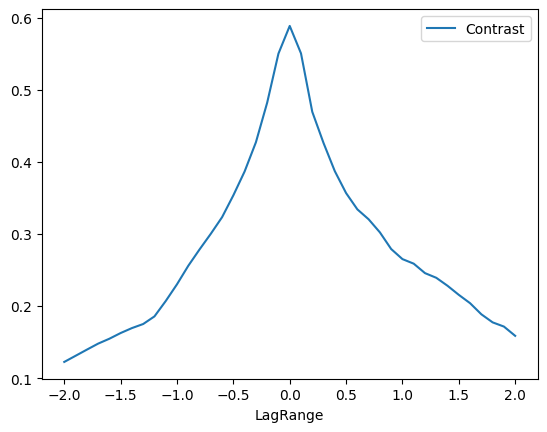

In [14]:
ll = lead_lag.LeadLag(
    ts1=ts1,
    ts2=ts2,
    max_lag=2,  # [-X seconds, +X seconds]
    verbose=True,
    min_precision=0.1
)
ll.run_inference()
ll._contrasts_to_df().plot()

In [16]:
ll._contrasts_to_df()

,Contrast
LagRange,
-2.0,0.122492
-1.9,0.130962
-1.8,0.139473
-1.7,0.147830
-1.6,0.154644
-1.5,0.162548
-1.4,0.169398
-1.3,0.175051
-1.2,0.185609


In [15]:
ll.llr

1.1148165856102574

/var/folders/44/shglypds2hd5yy5kdnt586h00000gn/T/ipykernel_87100/3232292957.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{i*100}ms' for i in range(-n_lags, n_lags+1)])


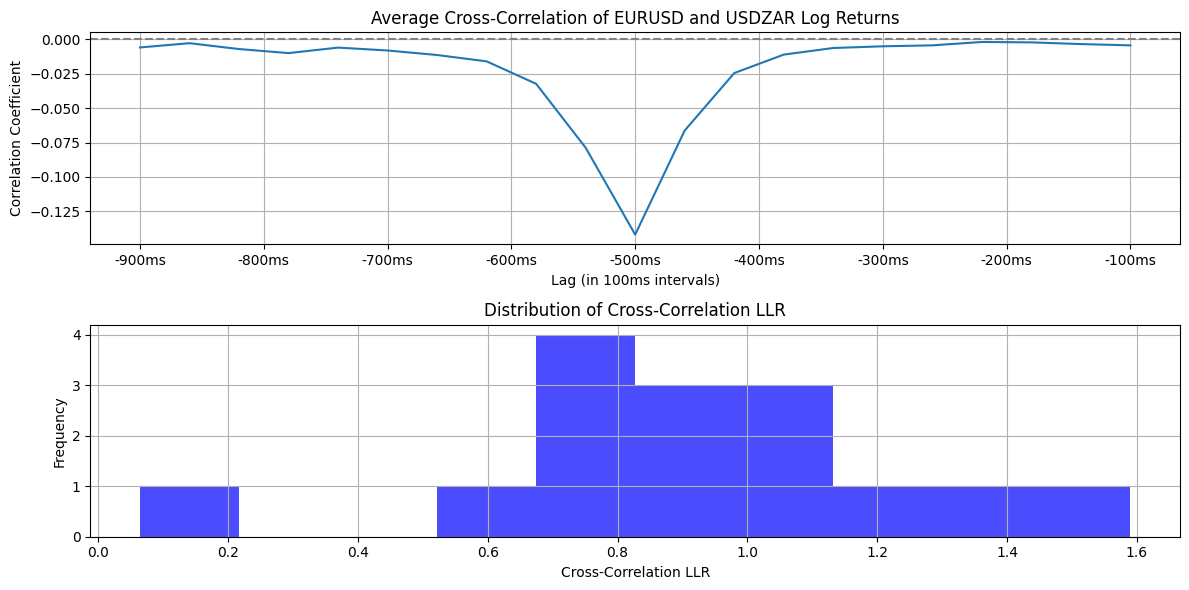

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(df_cross_corr.mean(axis=0))
ax[0].set_title('Average Cross-Correlation of EURUSD and USDZAR Log Returns')
ax[0].set_xlabel('Lag (in 100ms intervals)')
ax[0].set_xticklabels([f'{i*100}ms' for i in range(-n_lags, n_lags+1)])
ax[0].set_ylabel('Correlation Coefficient')
ax[0].axhline(0, color='gray', linestyle='--')
ax[0].grid()
ax[1].hist(df_llr.dropna(), bins=10, alpha=0.7, color='blue')
ax[1].set_title('Distribution of Cross-Correlation LLR')
ax[1].set_xlabel('Cross-Correlation LLR')
ax[1].set_ylabel('Frequency')
ax[1].grid()
plt.tight_layout()
plt.show()


In [16]:
df_cross_corr.mean(axis=1)

2019-02-28   -0.034278
2019-03-01   -0.029508
2019-03-04   -0.017574
2019-03-05   -0.024689
2019-03-06   -0.019340
2019-03-07   -0.025442
2019-03-08   -0.026496
2019-03-11   -0.021554
2019-03-12   -0.021041
2019-03-13   -0.018621
2019-03-14   -0.016025
2019-03-15   -0.019065
2019-03-18   -0.018523
2019-03-19   -0.015938
2019-03-20   -0.013789
Freq: B, dtype: float64